# CUSTOMER ANALYSIS - Model Comparison

Using 2 clusters, 3 dimensions PCA :

1) Evaluate clustering results (silhouette score) CAH and DB Scan.

2) Compare visualizations

Conclusion :

CAH score : 0.44 // DB Scan : 0.

## LIBRARIES IMPORT

In [1]:
# Data process
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import time

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import normalize, StandardScaler, MaxAbsScaler

# Features Engineering
from sklearn.decomposition import PCA

# ML
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.cluster import AgglomerativeClustering

from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN

## DATA IMPORT

Get data from csv

In [2]:
df = pd.read_csv('marketing_campaign.csv', sep = '\t')

## DATA EXPLORATION

See what does data look like

In [3]:
#df.head()

## DATA PROCESSING

### Preprocess data according to data viz observations

In [4]:
df_p = df.drop(df[df.Year_Birth < 1920].index)

In [5]:
df_p.drop(df[df.Marital_Status =='Absurd'].index, inplace = True)
df_p.drop(df[df.Marital_Status =='YOLO'].index, inplace = True)
df_p.replace('Alone', 'Single', inplace = True)

In [6]:
df_p.drop(df[df.Income == 666666].index, inplace = True)

In [7]:
def convert_to_timestamp(x):
    """Convert date objects to integers"""
    return time.mktime(x.timetuple())

df_p['Dt_Customer'] = pd.to_datetime(df.Dt_Customer, dayfirst=True).apply(convert_to_timestamp)

In [8]:
df_p.dropna(inplace=True)

In [9]:
df_p.reset_index(inplace = True, drop = True)

In [10]:
#df_p.head()

### Features selection and encoding

Slice df to define X_1, matrix of numerical features

In [11]:
X_1 = df_p[['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']]

Label encode Education and Marital Status features

In [12]:
le = LabelEncoder()

In [13]:
edu = le.fit_transform(df_p['Education'])
marit = le.fit_transform(df_p['Marital_Status'])

Definition of df X_2, matrix of encoded features

In [14]:
X_2 = pd.concat([pd.DataFrame(edu.reshape((-1, 1))), pd.DataFrame(marit.reshape((-1, 1)))], axis = 1)
X_2.columns = ['Education', 'Marital_Status']

Definition of X, matrix of all features

In [15]:
X = pd.concat([X_1, X_2], axis = 1)
#X

### Features Standardization

In [16]:
#X_n = pd.DataFrame(normalize(X, axis = 0), columns = X.columns)
scaler = StandardScaler()
#scaler = MaxAbsScaler()

#scaler

In [17]:
#scaler.fit(X)
#scaler.mean_

In [18]:
X_n = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
#X_n.head()

## FEATURES ENGINEERING (PCA)

In [19]:
n_components = 3

In [20]:
pca = PCA(n_components = n_components)

In [21]:
pca.fit(X_n)

PCA(n_components=3)

In [22]:
#X_n.shape

In [23]:
X_pca = pca.transform(X_n)
 
# Check the dimensions of data after PCA
#X_pca.shape

In [24]:
#pd.DataFrame(X_pca)

In [25]:
# Dump components relations with features
#pd.DataFrame(pca.components_,columns=X.columns,index = ['PC-1','PC-2','PC-3'])

## CLASSIFICATION

In [26]:
n_clusters = 3
random_state = 130

### CAH

#### Train

In [27]:
model_cah = AgglomerativeClustering(n_clusters = n_clusters)

# Segmentation à l'aide d'une CAH
y_pred_cah = model_cah.fit_predict(X_pca)

#### Evaluation

In [28]:
sil_cah = silhouette_score(X_pca, model_cah.labels_)
round(sil_cah, 2)

0.38

#### Visualization

Text(0, 0.5, 'pc3')

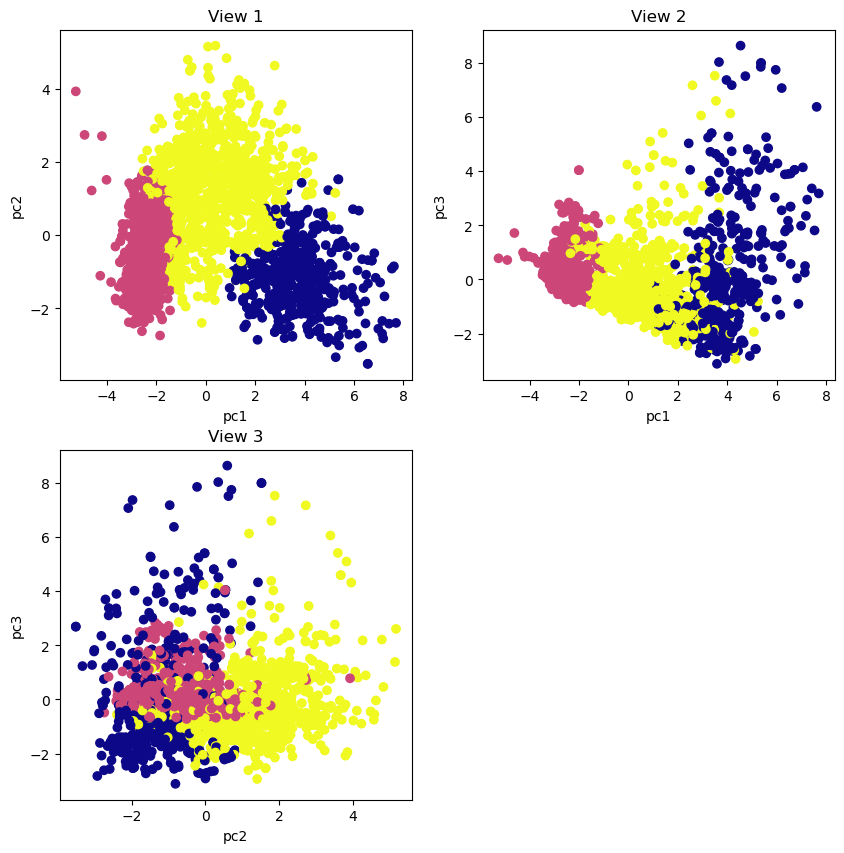

In [29]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)

plt.scatter(X_pca[:,0], X_pca[:,1], c = y_pred_cah, cmap='plasma')
plt.title('View 1')
plt.xlabel('pc1')
plt.ylabel('pc2')


plt.subplot(2, 2, 2)

plt.scatter(X_pca[:,0], X_pca[:,2], c = y_pred_cah, cmap='plasma')
plt.title('View 2')
plt.xlabel('pc1')
plt.ylabel('pc3')


plt.subplot(2, 2, 3)

plt.scatter(X_pca[:,1], X_pca[:,2], c = y_pred_cah, cmap='plasma')
plt.title('View 3')
plt.xlabel('pc2')
plt.ylabel('pc3')

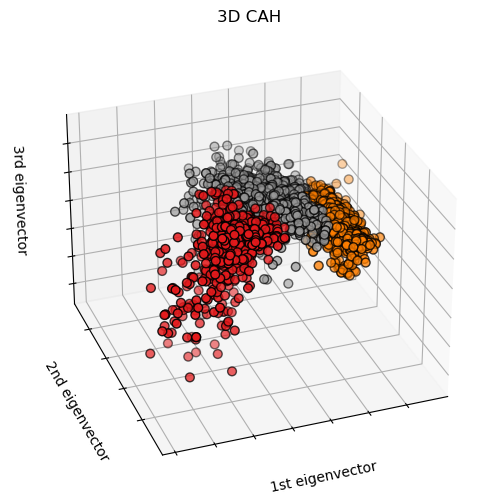

In [30]:
# To getter a better understanding of interaction of the dimensions, plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = X_pca
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=y_pred_cah,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

ax.set_title("3D CAH")
ax.set_xlabel("1st eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.zaxis.set_ticklabels([])

plt.show()

### DB Scan

Quelle distance ε pour déterminer pour chaque observation le ε-voisinage ?

Quel est le nombre minimal de voisins nécessaire pour considérer qu’une observation est une observation cœur ?

Une méthode simple pour optimiser le ε consiste à regarder pour chaque observation à quelle distance se situe son voisin le plus proche.

Ensuite il suffit de fixer un ε tel qu’une part « suffisamment grande » des observations aient une distance à son plus proche voisin inférieure à ε.

Par « suffisamment grande » on entend 90-95% des observations qui doivent avoir au moins un voisin dans leur ε-voisinage

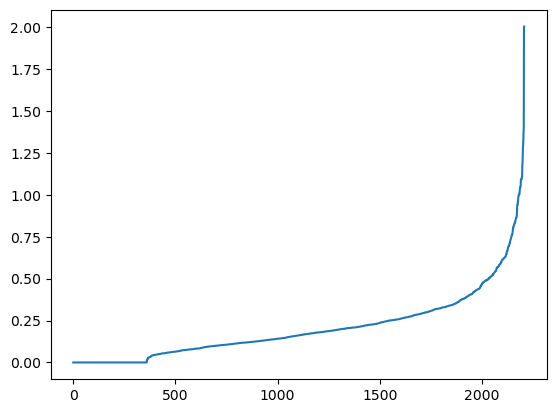

In [31]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances);

2208 * 0.9 = 1990 => eps = 0.5

#### Train

In [32]:
model_dbs = DBSCAN(eps = 0.5, min_samples = 5)

y_pred_dbs = model_dbs.fit_predict(X_pca)

#### Evaluation

In [33]:
pd.DataFrame(model_dbs.labels_)[0].unique()

array([ 0, -1,  1,  3,  2,  4,  7,  5,  6], dtype=int64)

In [34]:
sil_dbs = silhouette_score(X_pca, model_dbs.labels_)
round(sil_dbs, 2)

-0.18

In [35]:
pd.DataFrame(model_dbs.labels_)[0].unique().shape

(9,)

#### Visualization

In [36]:
#plt.scatter(X_pca[:,0], X_pca[:,1], c = y_pred_dbs,  cmap = 'plasma');

#plt.title('DB SCAN')
#plt.xlabel('pc1')
#plt.ylabel('pc2')

Text(0, 0.5, 'pc3')

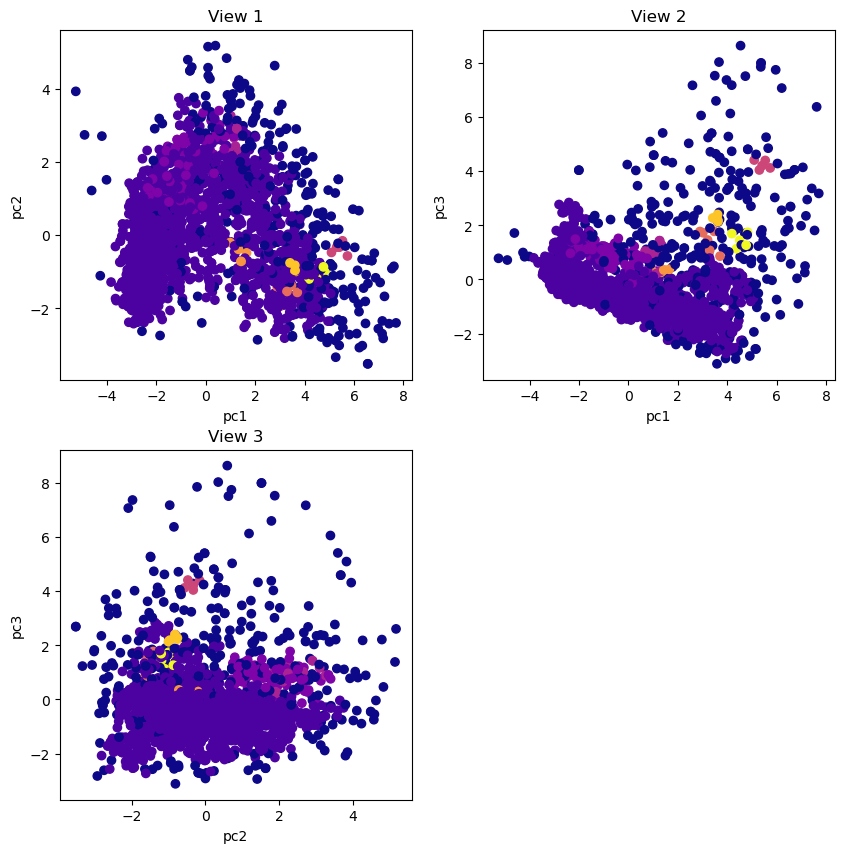

In [37]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)

plt.scatter(X_pca[:,0], X_pca[:,1], c = y_pred_dbs, cmap='plasma')
plt.title('View 1')
plt.xlabel('pc1')
plt.ylabel('pc2')


plt.subplot(2, 2, 2)

plt.scatter(X_pca[:,0], X_pca[:,2], c = y_pred_dbs, cmap='plasma')
plt.title('View 2')
plt.xlabel('pc1')
plt.ylabel('pc3')


plt.subplot(2, 2, 3)

plt.scatter(X_pca[:,1], X_pca[:,2], c = y_pred_dbs, cmap='plasma')
plt.title('View 3')
plt.xlabel('pc2')
plt.ylabel('pc3')

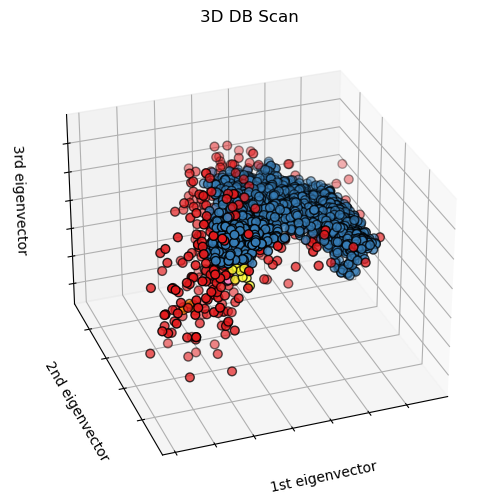

In [38]:
# To getter a better understanding of interaction of the dimensions, plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110) #-150/110

X_reduced = X_pca
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=y_pred_dbs,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

ax.set_title("3D DB Scan")
ax.set_xlabel("1st eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.zaxis.set_ticklabels([])

plt.show()